In this notebook, using two different examples, the Auto Regressive Cepstral Coefficients and Real Cepstral Coefficients **are compared** regarding their discriminatory power in grasping the inner patterns of time series.  
Regarding reliable examinations, similar time windows are found using the `stumpy` package. The package is prominent in the time series pattern matching domain and can be referred to as a reference. After finding similar time windows using `stumpy`, I examine the eligibility of cepstral coefficients regarding their ability to discern the underlying patterns of time series. The procedure is as follows:  
1. Find similar pairs of time windows using `stumpy`
2. Calculate the cepstral coefficients of two similar time windows (cc1 and cc2) and a different one (cc3).
3. Calculate the Euclidean distance between each pair of calculated cepstral coefficients (i.e., Euclidean distance between (cc1 and cc3), (cc2, cc3), and (cc1, cc2). Presuming the valid efficiency of cepstral coefficients, I expect $euclidean(cc1, cc2)<euclidean(cc2, cc3)$ and $euclidean(cc1, cc2)<euclidean(cc1, cc3)$).

Two different methods for calculating cepstral coefficients are provided here
- Auto-Regressive Cepstral Coefficients (ARCepstral)
- Real Cepstral Coefficients

# ARCepstral
The cepstrum of an ARIMA time–series can be estimated using the parameters of an ARIMA model for that time–series. Consider a time–series $X_t$ defined by an $AR(p)$ model $X_t+\alpha_1X_{t-1}+\ldots+\alpha_pX_{t-p}=\epsilon_t$ where $\alpha_1+\ldots+\alpha_p$ are the auto-regression coefficients and $\epsilon_t$ is white noise with mean 0 and certain non zero variance. Note that for every ARIMA model, an equivalent AR model can be obtained from the ARIMA model by polynomial division.  
The cepstral coefficients for an $AR(p)$ time–series can be derived from the auto-regression coefficients [[1](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=S.+Furui.+Digital+Speech+Processing%2C+Synthesis%2C+and+Recognition.+Marcel+Deckker%2C+Inc.%2C+New+York%2C+1989.&btnG=)]:
$$
{c_n} = \left\{ {\begin{array}{*{20}{c}}
  { - {\alpha _1},}&{{\text{if n = 1}}} \\ 
  { - {\alpha _n} - \sum\nolimits_{m = 1}^{n - 1} {\left( {1 - \frac{m}{n}} \right){\alpha _m}{c_{n - m}},} }&{{\text{if }}1 < n \leqslant p} \\ 
  { - \sum\nolimits_{m = 1}^p {\left( {1 - \frac{m}{n}} \right){\alpha _m}{c_{n - m}},} }&{{\text{if }}p < n} 
\end{array}} \right.
$$

# Real Cepstral
The real cepstrum is defined as the inverse Fourier transform of the real logarithm of the Fourier transform of the time series [[2](https://doi.org/10.1016/j.eswa.2020.113705
)]. 


# Import the required packages

In [1]:
using PythonCall
using YFinance
stumpy = pyimport("stumpy")
np = pyimport("numpy")
include("../src/CepstralClustering.jl")
using .CepstralClustering
import PythonPlot as plt

# Find similar Time windows using `stumpy`
The daily adjusted close price of the Intel Corporation from 19th October 2018 to 17th March 2020 is fetched using the `YFinance.jl` package. The time series passed to the `stumpy` package to find pairs of similar time windows.

In [2]:
series = get_prices("INTC", startdt="2018-10-19", enddt="2020-03-17")["adjclose"];
prof = stumpy.stump(series, 100)
p = pyconvert(Array, prof);

# 1st example

In [3]:
motif_idx = sortperm(p[:, 1])[100]
@info motif_idx
pair = pyconvert(Integer, p[motif_idx, 2])
@info pair

[ Info: 250
[ Info: 42


According to the result of the cell above, the 250th window is similar to the 42th window.

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


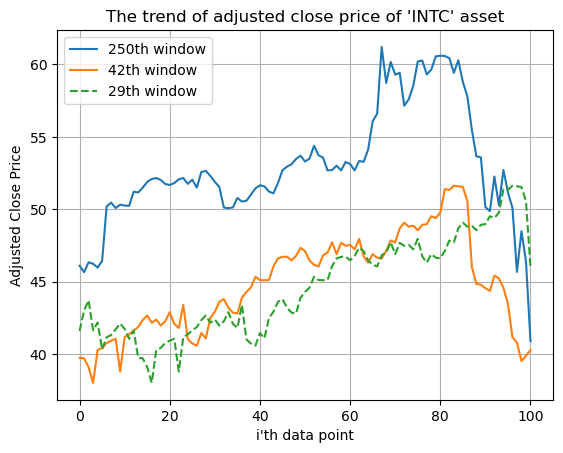

In [4]:
plt.plot(series[250:250+100], label="250th window")
plt.plot(series[42:42+100], label="42th window")
plt.plot(series[29:29+100], linestyle="--", label="29th window")
plt.xlabel("i'th data point")
plt.ylabel("Adjusted Close Price")
plt.title("The trend of adjusted close price of 'INTC' asset")
plt.grid()
plt.legend()
plt.show()

As can be seen from the figure above, the 250'th and the 42'th windows share common patterns in this frame. Thus, it is expected to see the minimum cepstral distance between these two series compared with other possible pairs (i.e., the 29th and the 250th windows). 

## ARCepstral

In [5]:
cc1 = cc(ARCepstral, series[250:250+100], 1, 5)
cc2 = cc(ARCepstral, series[42:42+100], 1, 5)
cc3 = cc(ARCepstral, series[29:29+100], 1, 5)
euc(v1, v2) = (v1.-v2).^2 |> sum |> sqrt
@info euc(cc1, cc2)
@info euc(cc1, cc3)
@info euc(cc2, cc3)

[ Info: 0.023242059156632074
[ Info: 0.02653914201181757
[ Info: 0.0032972074320000468


The results indicate that the 42th and 29th windows are expected to share similar patterns. The figure above shows that the 250th and 42th windows share a similar pattern. Thus, the results do not verify the expected outcome.

## Real Cepstral

In [6]:
cc1 = cc(RealCepstral, series[250:250+100], 5, 5)
cc2 = cc(RealCepstral, series[42:42+100], 5, 5)
cc3 = cc(RealCepstral, series[29:29+100], 5, 5)
@info euc(cc1, cc2)
@info euc(cc1, cc3)
@info euc(cc2, cc3)

[ Info: 0.1079402812813181
[ Info: 0.36079473191230965
[ Info: 0.3847952835795152


The results show that the 250th and 42th windows should share the most similar patterns compared to the other pairs (i.e., the 42th and 29th windows). The results can be testified by the visualization above.

# 2nd example

In [7]:
motif_idx = sortperm(p[:, 1])[75]
@info motif_idx
pair = pyconvert(Integer, p[motif_idx, 2])
@info pair

[ Info: 228
[ Info: 28


According to the result of the above cell, the 228th window is similar to the 28th window. 

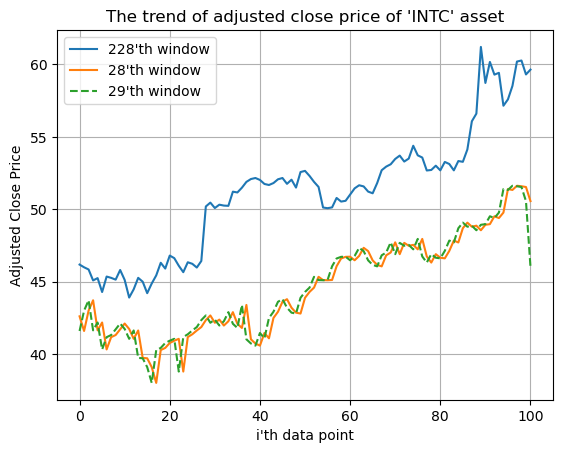

In [8]:
import PythonPlot as pl
plt.plot(series[motif_idx:motif_idx+100], label="228'th window")
plt.plot(series[pair:pair+100], label="28'th window")
plt.plot(series[29:29+100], linestyle="--", label="29'th window")
plt.xlabel("i'th data point")
plt.ylabel("Adjusted Close Price")
plt.title("The trend of adjusted close price of 'INTC' asset")
plt.grid()
plt.legend()
plt.show()

As can be seen from the figure above, the 28th and 29th windows mirror each other (apparently, since they are two consecutive windows). Thus, expectedly, their cepstral coefficients must have a lower distance from each other compared to the distance from the cepstral coefficients of the 228'th window.

## ARCepstral

In [9]:
cc1 = cc(ARCepstral, series[29:29+100], 1, 5)
cc2 = cc(ARCepstral, series[pair:pair+100], 1, 5)
cc3 = cc(ARCepstral, series[motif_idx:motif_idx+100], 1, 5)
@info euc(cc1, cc2)
@info euc(cc1, cc3)
@info euc(cc2, cc3)

[ Info: 0.05345258099023834
[ Info: 0.06631150574743176
[ Info: 0.012861503670875981


The results indicate that the 28th and 228th windows should share the most similar patterns to other pairs. According to the visualized series (provided in three cells earlier), this cannot be verified. Thus, in this case, it can be claimed that AR cepstral coefficients are not successful in identifying the inherent patterns of the time series.

## RealCepstral

In [10]:
cc1 = cc(RealCepstral, series[29:29+100], 5, 5)
cc2 = cc(RealCepstral, series[pair:pair+100], 5, 5)
cc3 = cc(RealCepstral, series[motif_idx:motif_idx+100], 5, 5)
@info euc(cc1, cc2)
@info euc(cc1, cc3)
@info euc(cc2, cc3)

[ Info: 0.18025551920017555
[ Info: 0.38732294441285037
[ Info: 0.5386711916501659


In terms of using the real cepstral coefficients, the results are in accordance with the visualized figure, and the 28th and 29th windows share the most similar pattern in this comparison; this can be verified by the visualization above.

# Conclusion
According to the results, the Real Cepstral method performs better than the AR Cepstral method in presenting the inner patterns of time series through several coefficients.